# scikit-learnの基礎

## MNISTデータを読み込む

MNISTのデータはいくつかの機会学習系のライブラリで簡単に使用できるように用意されているが、今回はscikit-learnに用意されているものを使用する。

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets
X, y = datasets.fetch_openml('mnist_784', return_X_y=True, data_home='./mnist', parser="auto")

上記の`fetch_openml`において第1引数の`mnist_784`はデータセットの名前で、今回の場合はMNISTという28x28(=784)の手書き数字を表わす白黒画像が含まれたものを使用する。ダウンロード元の[OpenML](https://www.openml.org/search)では、他にも多くのデータセットが利用可能なので、興味のあるデータを検索してみると良い。

また`return_X_y`は関数の戻り値が画像データ`X`とラベル`y`になるようにするためのフラグで、最後の`data_home`は二度目以降にデータセットを使用するときに再度ダウンロードしないよう、データをキャッシュしておくディレクトリを指定している。なお、特に`data_home`を指定しない場合はホームディレクトリに`scikit_learn_data`というディレクトリが作成され、その中にデータがキャッシュされる。一度目に上記のコードを実行すると、データのダウンロードに時間がかかるが、二度目以降はキャッシュされたデータを読み込むため時間が短縮される (それでも数秒はかかる)。

上記、scikit-learnの関数で得られるデータは[Pandas](https://pandas.pydata.org/)の`DataFrame`という方になっているので、扱いやすいようにNumPyの配列に変換して、画像が見られるように28x28に変形する。

In [2]:
# NumPyの配列に変更
X = np.array(X, dtype='float32')
y = np.array(y, dtype='uint8')
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


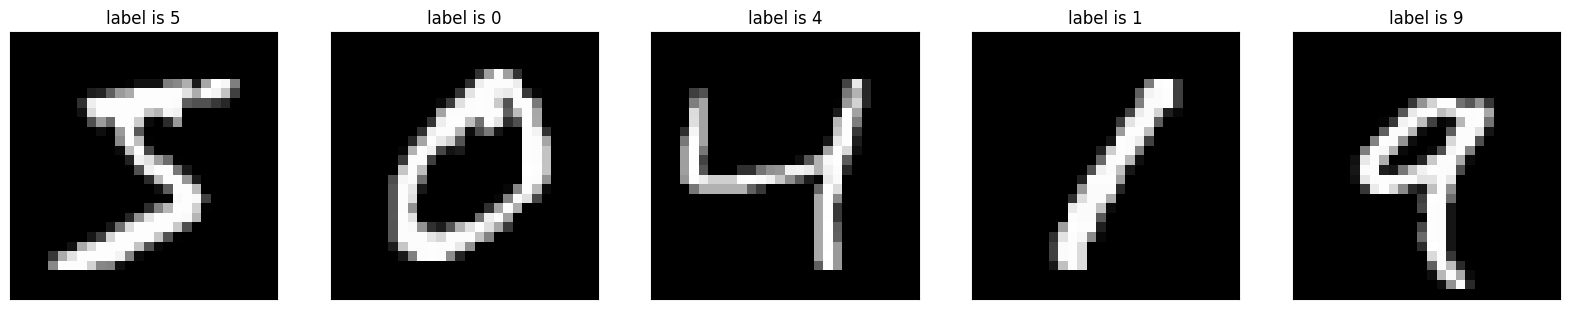

In [3]:
# 画像として見られるように配列の形を変更
X = np.reshape(X, (-1, 28, 28))

# 最初の5枚を確認してみる
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(X[i], cmap="gray")
    axs[i].set_title("label is {:d}".format(y[i]))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

上の結果を確認してみると「5」の手書き画像に対して"5"というラベルが対応していることが分かる。以後は、このデータを使って数字の認識を試みる。

なお、上記のデータは訓練用のデータが60000枚、テスト用のデータが10000で合計70000のデータとなっているため、以下のコードで訓練用とテスト用のデータを分けておく。

In [4]:
from sklearn import model_selection
X_train, X_test = model_selection.train_test_split(X, train_size=60000, test_size=10000, shuffle=False)
y_train, y_test = model_selection.train_test_split(y, train_size=60000, test_size=10000, shuffle=False)

## 高次元データの可視化

上記のMNISTの画像は$29\times28$の大きさを持つため、見方を変えると784次元ベクトルと見なすこともできる。このような高次元データを人間にも分かりやすく可視化する方法に**次元圧縮**がある。次元圧縮には**主成分分析**(PCA=Principle Component Analysis)や**MDS** (Multi-Dimensional Scaling)のような線形の次元圧縮法と、**LLE** (Locally Linear Embedding)や**Isomap**のような非線形の次元圧縮がある。

以下では実装が簡単なPCAと合わせて、scikit-learnのLLE, Isomapを用いてデータの可視化を試みる。

### 主成分分析 (PCA)による次元圧縮

データを実際に分類する前に、784次元ベクトルを主成分分析(PCA = principal component analysis)で低次元ベクトルに変換して、データの分布がどのようになっているかを見てみよう。

主成分分析とは、多次元空間$\mathbb{R}^n$上のデータ $x\in\mathbb{R}^n$(多次元空間における点)の分布方向を分析する手法で、データ点の共分散行列$C = (x - \bar{x})(x - \bar{x})^T$を固有値分解することで実現される。この際、得られる固有ベクトルはデータの主要な散らばりの方向を表わし、各固有値はその散らばりの大きさを表わす。

主成分分析には共分散行列の固有ベクトルを利用するため、まずはデータ`X`から共分散行列を計算し、その固有ベクトルを求める。`numpy.linalg.eigh`で求められる固有ベクトルは固有値の絶対値が小さい順で並んでいるので、固有値が大きい方から2つに対応する固有ベクトルを取り出して、各数字の784次元ベクトルを2次元空間に射影してみる。

In [5]:
# 1次元ベクトルに直しておく
X_train = np.reshape(X_train, (-1, 784))  
n_data = len(X_train)

# 共分散行列の計算
X_mu_train = np.mean(X_train, axis=0, keepdims=True)
C_train = np.dot((X_train - X_mu_train).T, X_train - X_mu_train) / n_data
# 固有値分解 (対称行列なのでeighを使う)
# 注意: NumPyとSciPyでは固有値の符号が変わることがあり, scikit-learnと結果を揃えるためにSciPyのeighを用いている
eigval, eigvec = sp.linalg.eigh(C_train)

# 固有値、固有ベクトルを絶対値降順に並び替える
eigval = np.flip(eigval)
eigvec = np.flip(eigvec, axis=1)

# 分散が最大の2方向を使って2次元空間に射影 (固有値は絶対値が小さい順に並んでいる)
Z_train = (X_train - X_mu_train) @ eigvec[:, :2]

これを各数字に別の色がつくようにMatplotlibを用いて可視化してみる。この際、何色がどの数字に対応するかが分かるように、`plt.legend`で凡例がつくようにしておこう。

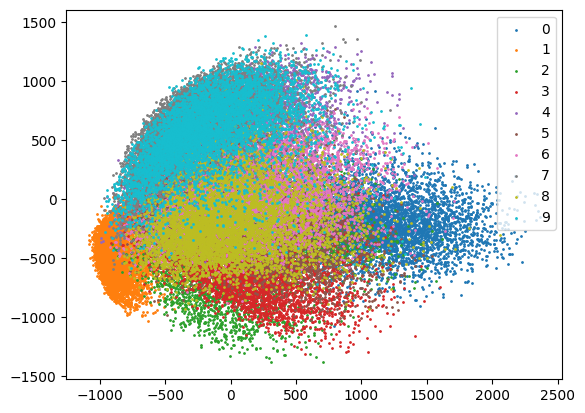

In [6]:
plt.figure()
for i in range(10):
    idx = np.where(y_train == i)
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=str(i), s=1)
plt.legend()
plt.show()

図を見てみると、概ね同じ数字が近くに集まってクラスタを形成していることが分かる。上図は2次元までベクトルを圧縮して作成しているため、数字同士の領域に大きな重複が見られるが、もう少し高い次元であれば、各数字の占める領域が重ならないようにすることができそうだ。

なお、PCAをscikit-learnを用いて実行する場合には、以下のようになる。

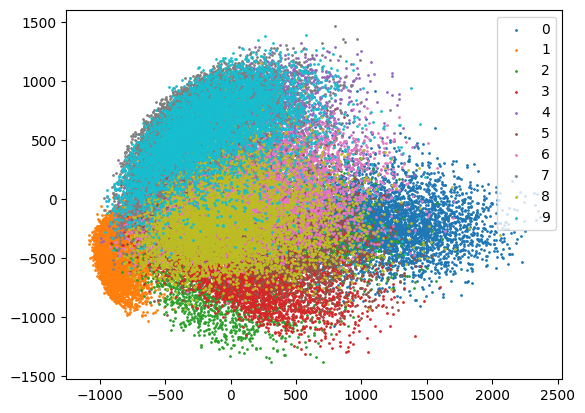

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
Z_train = pca.transform(X_train)

plt.figure()
for i in range(10):
    idx = np.where(y_train == i)
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=str(i), s=1)
plt.legend()
plt.show()

### MDSによる次元圧縮

MDSは距離空間学習法の一種で元の空間における点と点の距離をなるべく保つように低次元空間に点を射影する。今回は距離を通常のEuclidノルムで求めてMDSを実行して見よう。

まずは、各ベクトル同士の距離を求める。なお、32bit浮動小数で真面目に距離行列を求めてしまうとメモリを大量に使用するため、今回は先頭1000個のデータだけを使って実験する。

In [164]:
n = 1000
X_train_sub = X_train[:n]
X_train_sub_sq = np.sum(X_train_sub**2, axis=1)
X_train_sub_inner = X_train_sub @ X_train_sub.T
D = X_train_sub_sq[:, None] - 2.0 * X_train_sub_inner + X_train_sub_sq[None, :]

MDSでは、この距離行列が

In [165]:
H = np.eye(n) - np.ones((n, n)) / n
K = -0.5 * (H @ (D**2) @ H)
eigval, eigvec = sp.linalg.eigh(K)

eigval = np.flip(eigval)
eigvec = np.flip(eigvec, axis=1)

Z_train = eigvec[:, :2] @ np.diag(np.sqrt(eigval[:2]))

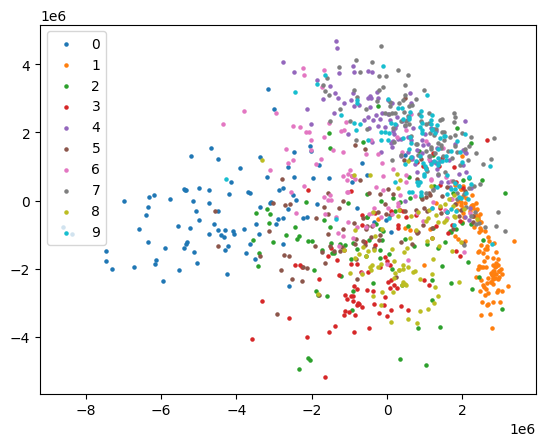

In [166]:
plt.figure()
for i in range(10):
    idx = np.where(y_train[:n] == i)
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=str(i), s=5)
plt.legend()
plt.show()

In [171]:
from sklearn.manifold import MDS

# 距離行列が求まっている場合には「dissimilarity="precomputed"」を指定する
mds = MDS(n_components=2, dissimilarity="precomputed", max_iter=200, normalized_stress=False)
Z_train = mds.fit_transform(D)

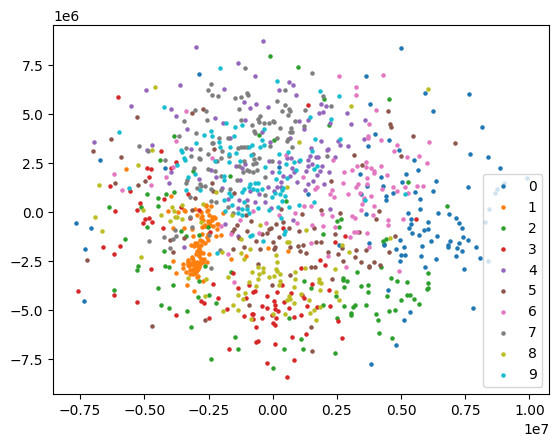

In [172]:
plt.figure()
for i in range(10):
    idx = np.where(y_train[:n] == i)
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=str(i), s=5)
plt.legend()
plt.show()

### Isomapによる次元圧縮

実はIsomapはMDSを拡張した物で、距離行列にk-nearest neighbor graph (kNNグラフ)と呼ばれる、各点とその近傍を結んだグラフ構造上で計算された距離を用いる。このようなグラフを作成するために、下記のコードでは [KD木](https://en.wikipedia.org/wiki/K-d_tree)を用いた最近某探索を用いる。

In [108]:
from sklearn.neighbors import NearestNeighbors

# 各データ点に対する最近傍点の探索
n_neighbors = 5
kd_tree = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm="kd_tree")
kd_tree.fit(X_train_sub)
distances, indices = kd_tree.kneighbors(X_train_sub)

# 自分自身までの距離を除去
distances = distances[:, 1:]
indices = indices[:, 1:]

ここで`distances`と`indices`は`[1000, 5]`の大きさのデータになっていて、各頂点に対する近傍点までの距離と、近傍点のインデックスが入っている。なお、探索元のデータ群と探索先のデータ群を同じにすると、`distances[:, 0]`が自分自身の点までの距離で0となってしまうため、kNNグラフを作る際には、このようなデータを除去しておく。

次にグラフ計算のためのライブラリである`networkx`を用いて、グラフ上での点と点の距離を計算する。まずはグラフの作成。`networkx`でグラフを作成するためには`(i, j, {"weight": 1.0})`のような辺の端点を表わす点のインデックス`i`, `j`と、辺に対する重みの除法を表わす`{"weight": 1.0}`を辺の数分だけ配列に格納し、その配列を用いて `from_edgelist` からグラフを作成する。

In [109]:
# kNNグラフの作成
import networkx as nx

# 辺のデータの収集
edges = []
for i in range(n):
    for j in range(n_neighbors):
        edges.append((i, indices[i, j], {"weight": distances[i, j]}))
        edges.append((indices[i, j], i, {"weight": distances[i, j]}))

# グラフの作成
G = nx.from_edgelist(edges)

グラフが作成できたら、[Warshall-Floyd法](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm)によって、全点対間の距離を計算する。なお、Warshall-Floyd法はグラフの頂点数 $n$に対して $O(n^3)$のアルゴリズムなので、計算量に注意すること。

In [110]:
# Warshall-Floyd法による全点対間距離の計算
# 注意: networkxのグラフのノードはインデックス順になっていないので、第2引数にノード順を指定する
D = nx.floyd_warshall_numpy(G, nodelist=np.arange(n))

ここまででkNNグラフ上での頂点間距離が

In [137]:
H = np.eye(n) - np.ones((n, n)) / n
K = -0.5 * (H @ (D**2) @ H)
eigval, eigvec = sp.linalg.eigh(K)

eigval = np.flip(eigval)
eigvec = np.flip(eigvec, axis=1)

# 注意: scikit-learnと結果を揃えるために-1を掛ける (固有値, 固有ベクトルの符号には曖昧さがある)
Z_train = -1.0 * eigvec[:, :2] @ np.diag(np.sqrt(eigval[:2]))

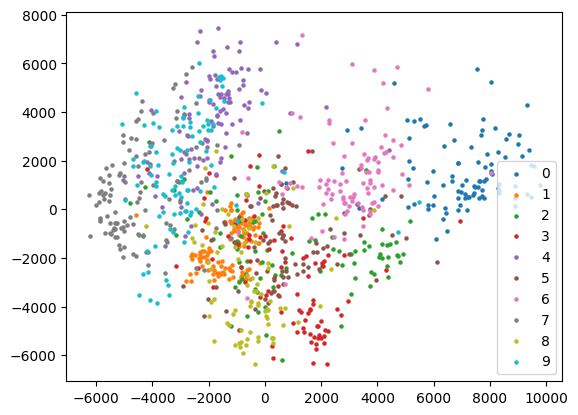

In [138]:
plt.figure()
for i in range(10):
    idx = np.where(y_train[:n] == i)
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=str(i), s=5)
plt.legend()
plt.show()

In [143]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_neighbors=5, neighbors_algorithm="kd_tree", path_method="FW")
Z_train = isomap.fit_transform(X_train[:n])

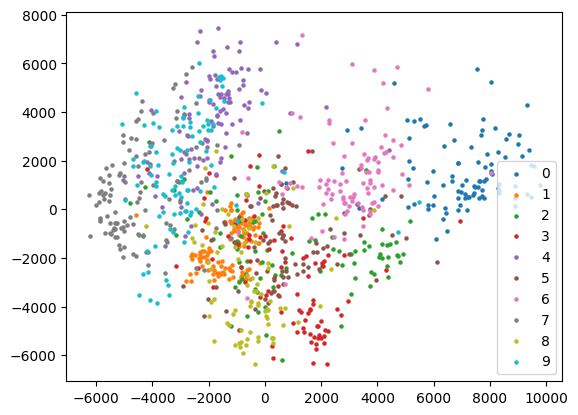

In [144]:
plt.figure()
for i in range(10):
    idx = np.where(y_train[:n] == i)
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=str(i), s=5)
plt.legend()
plt.show()

## Gauss混合分布 (GMM)による数字の分類